##### This requires that the Nontarget and KO files have identical line entries (i.e., each has PP_#### for KO and Nontarget)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from adjustText import adjust_text

# Load the data files
Nontarget = pd.read_csv('Sept_0812-15_NT_Chk.csv')
target = pd.read_csv('Sept_0812-15_Chk.csv')
name_df = pd.read_csv('proteomics_id_translator_240305.csv')

In [2]:
# Step 1: Translate Protein.Group names to locus
translator_dict = {}
nontranslated = 0
for orig_label in Nontarget['Protein.Group']:
    matching_idx = name_df['original'].str.contains(orig_label, regex=False)
    if sum(matching_idx) == 1:
        translator_dict[orig_label] = name_df.loc[matching_idx, 'locus'].values[0]
    else:
        translator_dict[orig_label] = orig_label  # Keep the original name if no match
        nontranslated += 1
print(f"In total, N = {nontranslated}/{len(Nontarget['Protein.Group'])} proteins were not translated to locus names")

# Apply the translation to both files
Nontarget['Protein.Group'] = Nontarget['Protein.Group'].map(translator_dict)
target['Protein.Group'] = target['Protein.Group'].map(translator_dict)

In total, N = 96/4512 proteins were not translated to locus names


C:\Users\dcarruth\AppData\Local\Temp\ipykernel_11436\2195595102.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_val = ttest_ind(group1, group2, equal_var=False)
C:\Users\dcarruth\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\dcarruth\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


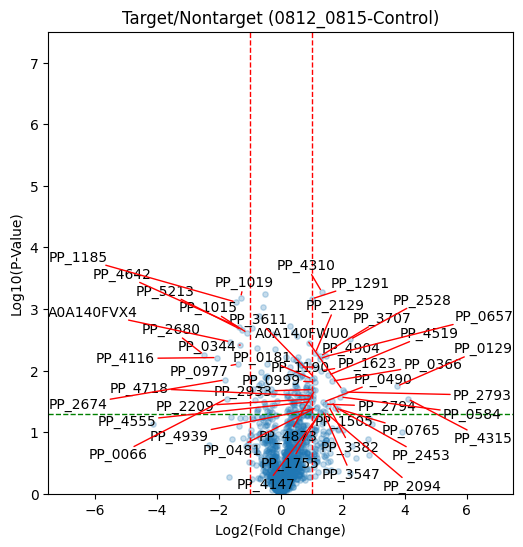

Log2 and Log10 values saved to 'log2_log10_values_by_sample.csv'


In [3]:
# Initialize a DataFrame to store log2 and log10 values for all samples
log2_log10_results = pd.DataFrame()

# Step 2: Loop over unique sample names
sample_names = Nontarget['Sample'].unique()

for sample in sample_names:
    # Filter data for the current sample
    Nontarget_sample = Nontarget[Nontarget['Sample'] == sample]
    target_sample = target[target['Sample'] == sample]

    # Filter for %_of protein_abundance_Top3-method > 0.01
    Nontarget_sample = Nontarget_sample[Nontarget_sample['%_of protein_abundance_Top3-method'] > 0.001]
    target_sample = target_sample[target_sample['%_of protein_abundance_Top3-method'] > 0.001]

    # Step 3: Compute mean %_of protein_abundance_Top3-method for each protein
    Nontarget_mean = Nontarget_sample.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()
    target_mean = target_sample.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()

    # Rename columns for clarity
    Nontarget_mean.rename(columns={'%_of protein_abundance_Top3-method': 'Nontarget_abundance'}, inplace=True)
    target_mean.rename(columns={'%_of protein_abundance_Top3-method': 'target_abundance'}, inplace=True)

    # Step 4: Merge the data on Protein.Group
    merged_data = pd.merge(Nontarget_mean, target_mean, on='Protein.Group', how='outer')  # Ensure all proteins are included

    # Step 5: Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['target_abundance'] / merged_data['Nontarget_abundance'])

    # Step 6: Compute p-values (assume replicates data exists for actual p-value calculation)
    Nontarget_reps = Nontarget_sample[['Protein.Group', '%_of protein_abundance_Top3-method']]
    target_reps = target_sample[['Protein.Group', '%_of protein_abundance_Top3-method']]

    p_values = []
    for protein in merged_data['Protein.Group']:
        group1 = Nontarget_reps[Nontarget_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        group2 = target_reps[target_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        if not group1.empty and not group2.empty:
            _, p_val = ttest_ind(group1, group2, equal_var=False)
        else:
            p_val = np.nan  # Assign NaN if data is missing
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Step 7: Ensure consistent row alignment in log2_log10_results
    if log2_log10_results.empty:
        log2_log10_results = merged_data[['Protein.Group']]  # Start with the first set of loci
    else:
        log2_log10_results = pd.merge(
            log2_log10_results,
            merged_data[['Protein.Group']],
            on='Protein.Group',
            how='outer'
        )

    # Add current sample's log2 and log10 values as new columns
    log2_log10_results = pd.merge(
        log2_log10_results,
        merged_data[['Protein.Group', 'log2_change', 'log10_p_value']],
        on='Protein.Group',
        how='outer'
    )

    log2_log10_results.rename(
        columns={'log2_change': f'{sample}_log2_change', 'log10_p_value': f'{sample}_log10_p_value'},
        inplace=True
    )

    # Step 8: Create volcano plot for the current sample
    fold_change = merged_data['log2_change']
    p_values = merged_data['log10_p_value']
    log_sig_thresh = 1
    log_fold_thresh = 0.05

    plt.figure(figsize=(6, 6))
    plt.scatter(fold_change, p_values, s=15, alpha=0.25)  # Adjust marker size and transparency as needed
    plt.title(f"Target/Nontarget ({sample})")  # Title reflects the sample name
    plt.xlabel("Log2(Fold Change)")
    plt.ylabel("Log10(P-Value)")
    plt.grid(False)
    plt.ylim(0, 7.5)  # Adjust y-axis range if needed
    plt.xlim(-7.5, 7.5)  # Adjust x-axis range if needed

    # Threshold lines for fold change and p-values
    plt.axvline(x=log_sig_thresh, color='r', linestyle='--', linewidth=1)  # Fold change > 2
    plt.axvline(x=-log_sig_thresh, color='r', linestyle='--', linewidth=1)  # Fold change < -2
    plt.axhline(y=-np.log10(log_fold_thresh), color='g', linestyle='--', linewidth=1)  # P-value < 0.01

    # Annotate points that meet specific conditions
    texts = []
    labels = merged_data['Protein.Group']  # Use translated locus names for annotation
    for i, label in enumerate(labels):
        if (fold_change[i] < -log_sig_thresh and p_values[i] > -np.log10(log_fold_thresh)) or (fold_change[i] > log_sig_thresh and p_values[i] > -np.log10(log_fold_thresh)):  # Modify conditions as necessary
            text = plt.text(fold_change[i], p_values[i], label, fontsize=10)
            texts.append(text)

    # Adjust text annotations to avoid overlaps
    if texts:
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))

    # Show the plot
    plt.show()

# Step 9: Save the log2 and log10 values to a CSV file
log2_log10_results.to_csv('log2_log10_values_by_sample.csv', index=False)
print("Log2 and Log10 values saved to 'log2_log10_values_by_sample.csv'")